In [11]:
import warnings

import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
# from lion_pytorch import Lion

from src.features import build_features_final, utils, build_features_optim
from src.models import predict_model
from src.train.train import train, evaluation, prediction_to_csv
from src.data.make_dataset import DatasetLoader
from src.config.config import seed_everything, cfg
from src.visualization.visual import plot_label_counts

warnings.filterwarnings(action='ignore')
seed_everything(cfg.SEED)

scaler = MinMaxScaler()

drop_feature = ['type', 'motor_hp', 'air_end_temp', 'motor_rpm', 'motor_temp', 'motor_vibe', 'motor_current',
                'air_inflow', "air_flow_pressure", "current_by_vibration", "airflow_per_rotation", 'volumetric_efficiency',
                'air_to_motor_ratio']


# 데이터 전처리
train_data = pd.read_csv(r'data\raw\train_data_copy.csv')
train_data = build_features_final.create_derived_features(train_data)
train_data = train_data.drop(drop_feature, axis=1)

test_data = pd.read_csv(r'data\raw\test_data_copy.csv')
test_data = build_features_final.create_derived_features(test_data)
test_data = test_data.drop(drop_feature, axis=1)
test_data_raw = test_data.copy()

scaled_train_data = scaler.fit_transform(train_data)
scaled_test_data = scaler.transform(test_data)

scaled_train_data_df = pd.DataFrame(
    scaled_train_data, columns=train_data.columns)
scaled_test_data_df = pd.DataFrame(
    scaled_test_data, columns=train_data.columns)

n_features = scaled_train_data_df.shape[1]
print(n_features)

scaled_train_data = scaled_train_data_df.values
scaled_test_data = scaled_test_data_df.values


# 데이터 로더
dataloader = DatasetLoader(scaled_train_data, scaled_test_data)
train_loader, test_loader = dataloader.load

# # 학습 파라미터
# model = predict_model.AutoEncoder(input_dim=n_features, latent_dim=128)
# model = predict_model.SingleAutoEncoder(input_dim=n_features, hidden_dim=128)
# model = predict_model.ResidualConv1DAutoencoder()
model = predict_model.ResidualConv1DLSTMAutoencoder()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# 학습
train(train_loader, model, criterion, optimizer)

# 예측
train_prediction, train_cosine = evaluation(train_loader, model)
print(max(train_cosine))
prediction, test_cosine = evaluation(test_loader, model, max(train_cosine))

# 제출W
submission = prediction_to_csv(prediction)


9
Epoch [0/500], Loss: 0.0876731
Epoch [100/500], Loss: 0.0008690
Epoch [200/500], Loss: 0.0013914
Epoch [300/500], Loss: 0.0003507
Epoch [400/500], Loss: 0.0002590
0.0027346890419721603
label
0    7045
1     344
Name: count, dtype: int64


In [7]:
test_data['label'] = prediction
test_data['treshold'] = test_cosine
def no_out(test_data):
    test7342 = test_data[7342:7361]
    no = test7342[test7342['label']==1]
    yes = test7342[test7342['label']==0]
    return yes, no

yes, no = no_out(test_data)

In [8]:
test_data.corr()

,air_inflow,air_end_temp,out_pressure,motor_current,motor_rpm,motor_temp,motor_vibe,air_flow_pressure,current_by_airflow,temp_diff,...,efficiency,volumetric_efficiency,fan_laws_6,performance_index,air_to_motor_ratio,air_to_power_ratio,mechanical_efficiency,out_pressure_squared,label,treshold
air_inflow,1.000000,0.610628,-0.007383,0.991016,0.518147,0.635348,0.946012,0.999874,-0.696893,-0.314748,...,-0.662017,0.550666,-0.222216,-0.008375,0.818732,-0.662515,0.287930,-0.007620,-0.021643,-0.000917
air_end_temp,0.610628,1.000000,-0.008984,0.685231,0.987989,0.995482,0.670457,0.610420,-0.118626,-0.799889,...,-0.825865,-0.207042,-0.474202,-0.733167,0.114845,-0.826538,0.873379,-0.009374,0.027028,0.004567
out_pressure,-0.007383,-0.008984,1.000000,-0.007960,-0.006895,-0.009131,-0.002926,0.008085,0.013296,0.005999,...,0.051330,-0.007665,0.851400,0.053146,-0.004250,-0.001497,0.028532,0.999635,-0.134412,-0.971601
motor_current,0.991016,0.685231,-0.007960,1.000000,0.594143,0.706455,0.954707,0.990873,-0.639530,-0.394392,...,-0.726103,0.483929,-0.265277,-0.108802,0.763928,-0.726660,0.354389,-0.008226,0.045522,0.002774
motor_rpm,0.518147,0.987989,-0.006895,0.594143,1.000000,0.981809,0.588670,0.517968,-0.006614,-0.801129,...,-0.798237,-0.335937,-0.471126,-0.802672,-0.005021,-0.798986,0.908606,-0.007275,-0.012577,0.002780
motor_temp,0.635348,0.995482,-0.009131,0.706455,0.981809,1.000000,0.691989,0.635140,-0.135191,-0.739290,...,-0.833227,-0.177822,-0.449503,-0.717140,0.147706,-0.833900,0.860723,-0.009521,0.010723,0.008404
motor_vibe,0.946012,0.670457,-0.002926,0.954707,0.588670,0.691989,1.000000,0.945951,-0.593737,-0.381046,...,-0.822013,0.461726,-0.253826,-0.116368,0.777791,-0.822945,0.292828,-0.003145,0.079129,-0.003333
air_flow_pressure,0.999874,0.610420,0.008085,0.990873,0.517968,0.635140,0.945951,1.000000,-0.696712,-0.314595,...,-0.661196,0.550603,-0.209023,-0.007498,0.818699,-0.662491,0.288314,0.007869,-0.023767,-0.015806
current_by_airflow,-0.696893,-0.118626,0.013296,-0.639530,-0.006614,-0.135191,-0.593737,-0.696712,1.000000,-0.013204,...,0.092986,-0.855068,0.025972,-0.565867,-0.846336,0.092403,0.045812,0.013390,0.303300,0.045905
temp_diff,-0.314748,-0.799889,0.005999,-0.394392,-0.801129,-0.739290,-0.381046,-0.314595,-0.013204,1.000000,...,0.590489,0.344387,0.521876,0.666814,0.119115,0.591002,-0.753654,0.006302,-0.123900,0.020724


In [9]:
def plot_label_counts(predictions, chunk_sizes):
    for i, (start, end) in enumerate(chunk_sizes):
        chunk = predictions[start:end]
        num_labels = len(chunk[chunk['label'] == 1])
        print(f"Chunk {i}: {num_labels} labels with value 1")
        plt.plot(chunk['label'])
        plt.show()

Chunk 0: 143 labels with value 1


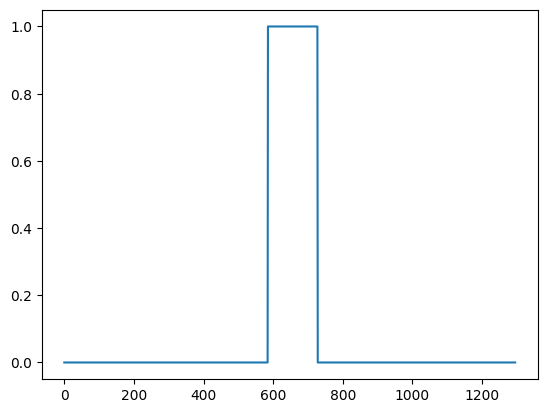

Chunk 1: 0 labels with value 1


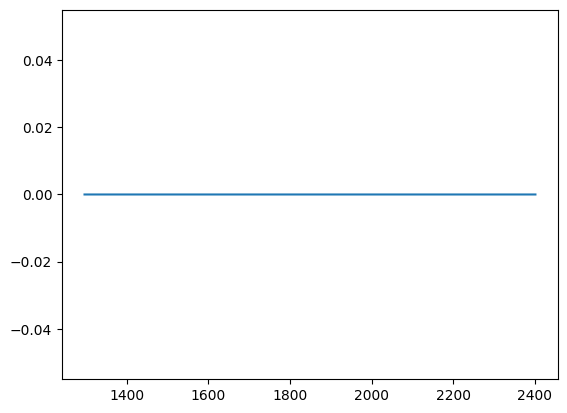

Chunk 2: 27 labels with value 1


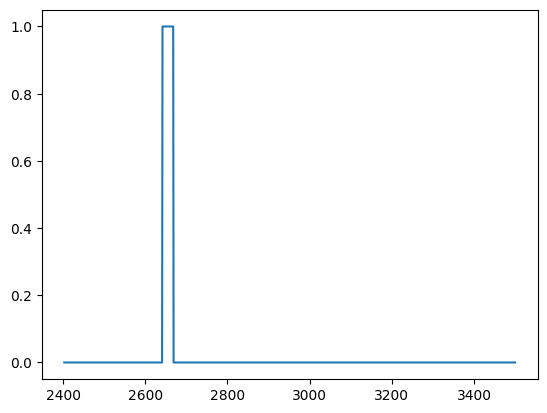

Chunk 3: 26 labels with value 1


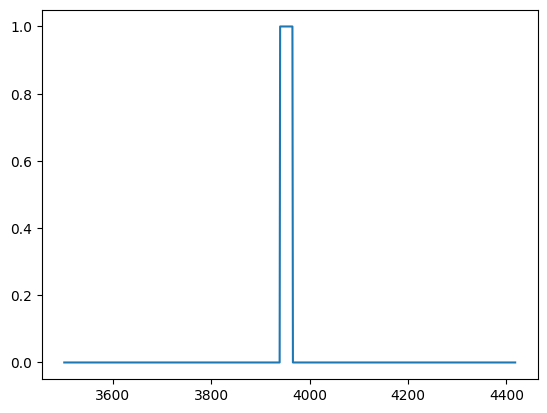

Chunk 4: 13 labels with value 1


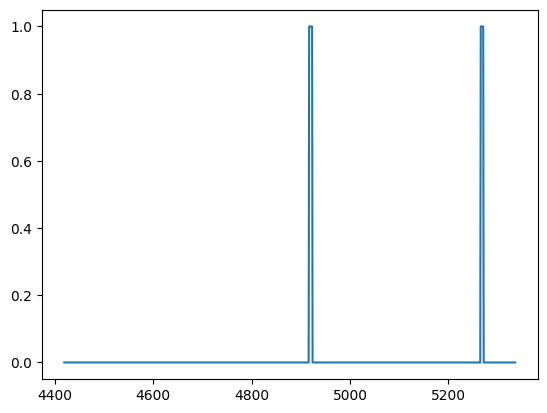

Chunk 5: 29 labels with value 1


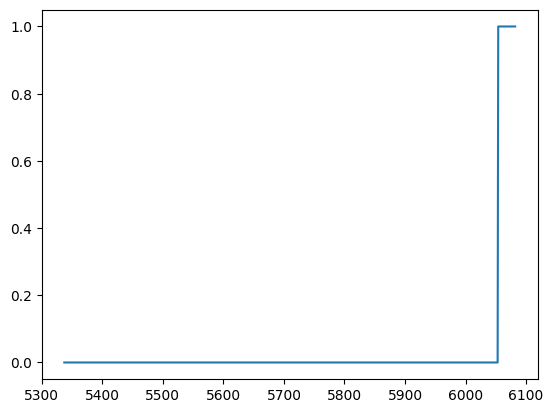

Chunk 6: 102 labels with value 1


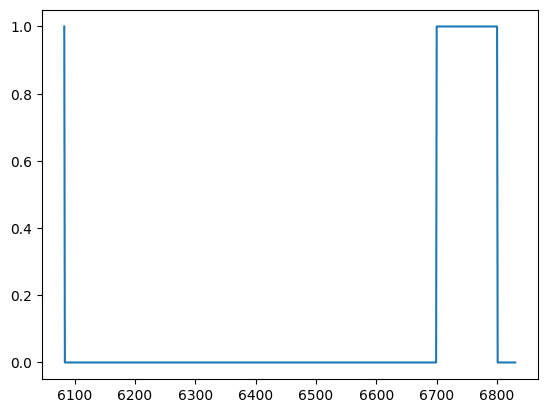

Chunk 7: 4 labels with value 1


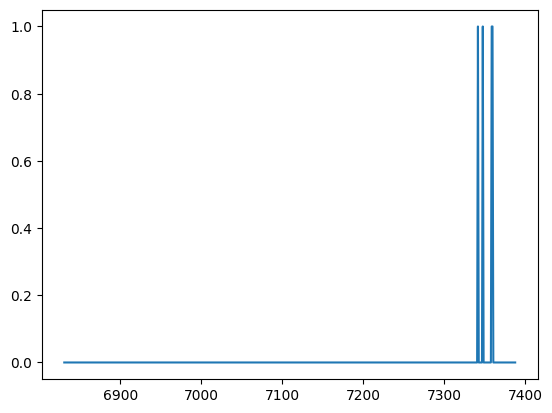

In [10]:
ranges = [(0, 1296), (1296, 2403), (2403, 3501), (3501, 4419), (4419, 5337), (5337, 6083), (6083, 6831), (6831, len(prediction))]
plot_label_counts(submission, ranges)